### <b>Credit Card Fraud Detection</b>
This project's data was taken from <a href='https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud'> this Kaggle dataset </a> by Machine Learning Group - ULB (Brussels University).<br>
Data from transactions in 2013 of European creditcard holders.<br><br>
This classification project is approached in a relatively straightforward way. <br><br> 
* The data provided by ML-ULB taken from their anonymized source, contains Time (second elapsed since transaction #1), 
* V1-V28 - 28 anonymized variables taken from a PCA transormation from perhaps more variables for data privacy, 
* the Amount column, which is the transaction amount (possibly in Euros), to aid in an example-dependent cost-sensitive learning, 
* then the Class variable - the target indicating 1 for Fraud and 0 for non-fraud.
<br><br>
##### Due to the PCA transform and scaling of the V1-V28 variables, there is little data preprocessing to do as most of the information is anonymized. However, there is still room for exploratory data analysis, as we you will see in the project below. <br><Br>

### _<b>1. The Beginning </b>_

In [3]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Checking for duplicates and dropping them.
print(f'There are {len(df[df.duplicated()==True])} duplicate rows in the data and totally {len(df)} rows in the dataset.')
df = df.drop_duplicates()
print(f'There are now {len(df)} rows in the dataset.')

There are 1081 duplicate rows in the data and totally 284807 rows in the dataset.
There are now 283726 rows in the dataset.


In [72]:
print(f'There are {df.isnull().sum().sum()} missing values in the data.')

There are 0 missing values in the data.


##### _The Amount Variable_
The amount variable was not transformed by ULB while providing the dataset. The transaction amount column distinctly makes the dataset and this particular classification problem unique. There will be more details why throughout this notebook, but a brief - business proboems like customer churn in a bank, loan default, credit scoring, and mainly (according to me), credit card fraud detection :- involve a high financial cost. A high financial cost and a strong economic reason for optimizing savings by preventing fraud differentiates this classification problem compated to generic classifications. <br><br>
The techniques used must not only aim to attain minimized loss functions for the classification algorithm, but also minimal financial costs (or maximized savings) through some domain knowledge. <br>
Some of the ideas I have are beyond the scope of this particular notebook, and are 100% ready for future implementation. Back to the point, the amount column will give us an insight into the nature of the transactions itself, which will help us understand the data better. <br><br>

In [5]:
# Basic descriptive statistics of the transaction amount column.,
df['Amount'].describe()

count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64

In [8]:
# How many zero amounts are there in the data?
zeros = len(df[df['Amount']==float(0)])
print(f'There are {zeros} zero amounts in the data.')

There are 1808 zero amounts in the data.


In [10]:
# How many of those 1808 zero amount transactions are fraud?
fraud_zeros = df.loc[(df['Amount']==float(0)) & (df['Class']==1)].shape[0]
print(f'Out of the 1808 zero transactions, {fraud_zeros} transactions are fraudulent.')

Out of the 1808 zero transactions, 25 transactions are fraudulent.


Zero transactions can be interpreted in many ways, but a plausible theory is that zero credit card transaction is when a card needs to be approved by the merchant and just charges a zero for the _"transaction"_ for verification. And it is also plausible that some of these might be fraud due to stolen credit card details or cards themselves, and then getting them approved by the user (thief)? Wild theories.

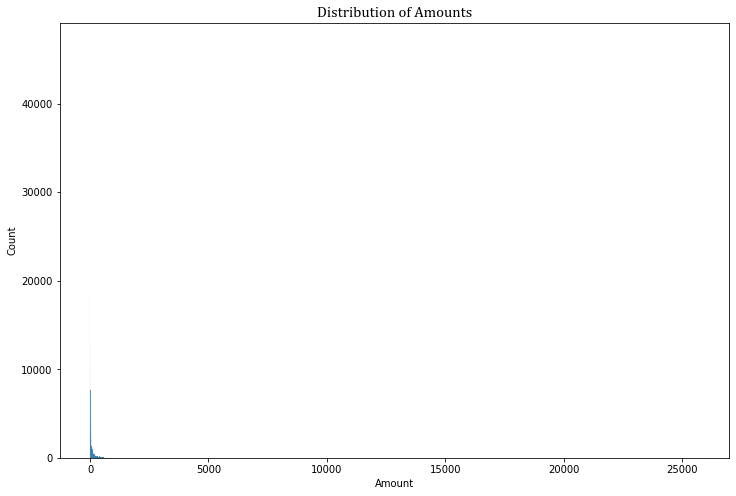

In [17]:
# A distribution ploit of the amount column will help us see how the shape of the data is.
plt.figure(figsize=(12,8))
sns.histplot(df[df['Amount']!=0.0]['Amount'])
plt.title('Distribution of Amounts', fontdict=dict(fontsize=15, fontfamily='Cambria'))
plt.show()

The amount column clearly has a long right tail. There seems to be a lot of transactions with amount less than 100, maybe?

In [16]:
print('The 75% (Q3) of the transaction amounts column is:', round(df['Amount'].describe()['75%'],2), 'units.')
print('Percentage of the data where the amount is lesser than 100 units is:', round((len(df[df['Amount']<100.0])/len(df))*100,2),'%')
print('Percentage of the data where the amount is less than or equal to 2 units is:', round((len(df[df['Amount']<=2.0])/len(df))*100,2),'%')

The 75% (Q3) of the transaction amounts columns is: 77.51 units.
Percentage of the data where the amount is lesser than 100 units is: 79.81 %
Percentage of the data where the amount is less than or equal to 2 units is: 16.87 %


Close to 80% of the data (227,000 approximate observations) has transaction amounts less than 100. While the 75% (Q3) value for the transaction amounts is 77.165, just about 2.5% of amounts lie between 77 to 100 units. 

It will be interesting to see the distribution of the amounts column for all amounts less than 100 units. Moreover, how many of the fraudulent transactions contain amounts less than 100 as a proportion of total frauds will be interesting to see. Let's get on with it!

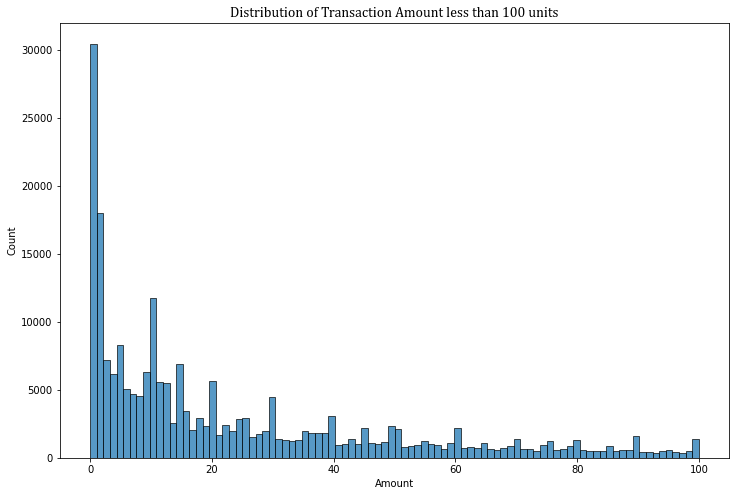

In [95]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Amount']<100]['Amount'])
plt.title('Distribution of Transaction Amount less than 100 units', fontdict=dict(fontsize=14, fontfamily='Cambria'))
plt.show()

In [96]:
df[df['Amount']>100]['Amount'].describe()

count    56399.000000
mean       348.279763
std        477.987853
min        100.010000
25%        141.000000
50%        204.820000
75%        367.985000
max      25691.160000
Name: Amount, dtype: float64

The top 20% of the amounts (amounts larger than 100 units) have a similar Q3 and mean value - which means that the Q3 to Max have some extremely large values. As we can see, 75% amounts is 368 and the maximum amount is 25,691 - close to 70 times higher.

In [97]:
print('{}% of the data has less than 1000 units amount.'.format(round((len(df[df['Amount']<1000])/len(df))*100,4)))

98.9201% of the data has less than 1000 units amount.


So, approximately 99% of amounts are less than 1000 Euros. Barring some outrageously large outliers such as 25,691 Euros, the transactions are right-skewed with 99% of the values between 0 and 1. <br><br>
Below is the graph that shows amounts from 0 to 1000 in the dataset.

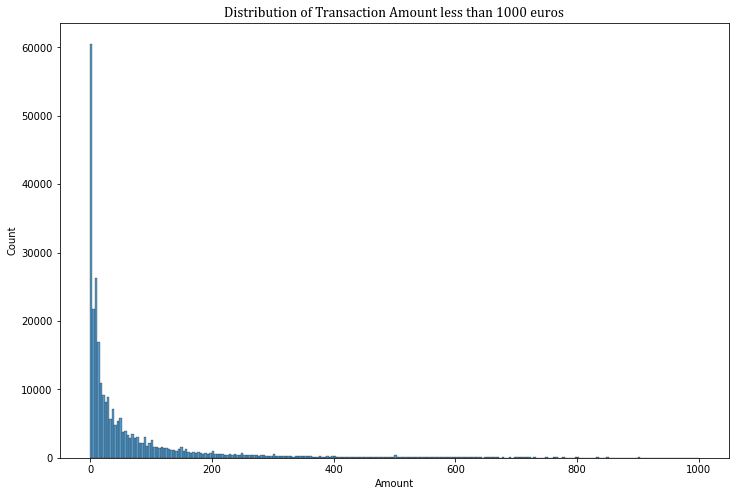

In [136]:
plt.figure(figsize=(12,8))
sns.histplot(df[df['Amount']<1000]['Amount'], bins=250)
plt.title('Distribution of Transaction Amount less than 1000 euros', fontdict=dict(fontsize=14, fontfamily='Cambria'))
plt.show()

There seems to be about 60,000 transactions with amounts less than 4 Euros.

In [99]:
proportion = df.loc[(df['Amount']<100) & (df['Class']==1)].shape[0]/df[df['Class']==1].shape[0]
total_frauds_100 = df.loc[(df['Amount']<100) & (df['Class']==1)].shape[0]
print('Proportion of the fraudulent transactions out of total frauds when amount is less than 100: {}%'.format(round((proportion*100),3)))
print('Total frauds when amount is less than 100: {} out of {}'.format(total_frauds_100, df[df['Class']==1].shape[0]))

Proportion of the fraudulent data out of total frauds when amount is less than 100: 73.573%
Total frauds when amount is less than 100: 348 out of 473


Nothing out of the ordinary - since close to 80% of the Amounts are lesser than 100, having 73.573% of the total fraudulent transactions fraud when amount is less than 100 is not too surprising.

It also means that the amount as a standalone variable is not enough to determine whether a transaction is a fraud or not.

### _<b>2. The Middle</b>_
Data understanding and preparations for classification!

In [22]:
print('Classes Value Counts')
print('-------------------------')
print(df['Class'].value_counts())
print('-------------------------')
print('Non-Fraud transactions constitute {}% of the dataset'.format(round(((len(df[df['Class']==0])/df.shape[0])*100), 2)))
print('Fraud transactions constitute {}% of the dataset'.format(round(((len(df[df['Class']==1])/df.shape[0])*100), 2)))

Classes Value Counts
-------------------------
0    283253
1       473
Name: Class, dtype: int64
-------------------------
Non-Fraud transactions constitute 99.83% of the dataset
Fraud transactions constitute 0.17% of the dataset


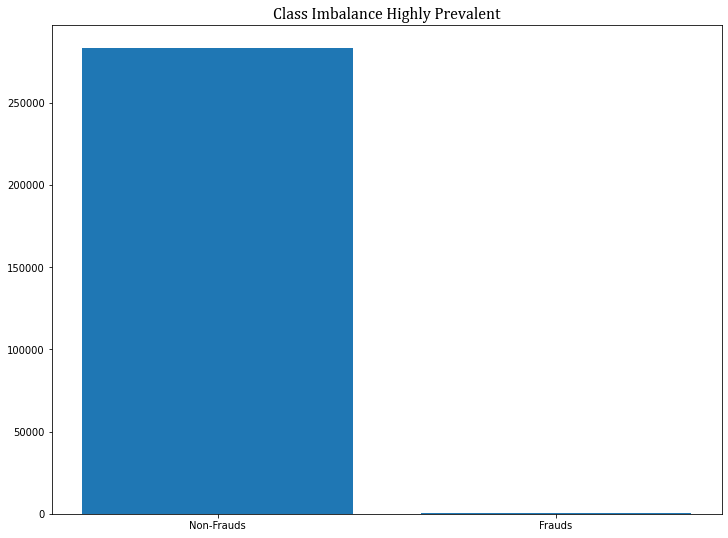

In [23]:
ratio_array = [df['Class'].value_counts()[0], df['Class'].value_counts()[1]]
plt.figure(figsize=(12,9))
plt.bar(x=['Non-Frauds', 'Frauds'], height=ratio_array)
plt.title('Class Imbalance Highly Prevalent', fontdict=dict(fontsize=16, fontfamily='Cambria'))
plt.show()

_This immensely imbalanced data is the reason why processes such as undersampling or oversampling is typically used to train the model with sufficient examples of both categories (in a binary classification problem) so that the model can be generalized well and not overfit on the training data. This has its own downsides based on the problem, or even in general, as we will see soon. For the Credit Card fraud detection example in this project however, I have my own reasons for why I choose NOT to resample the data for training, as you will see soon below._

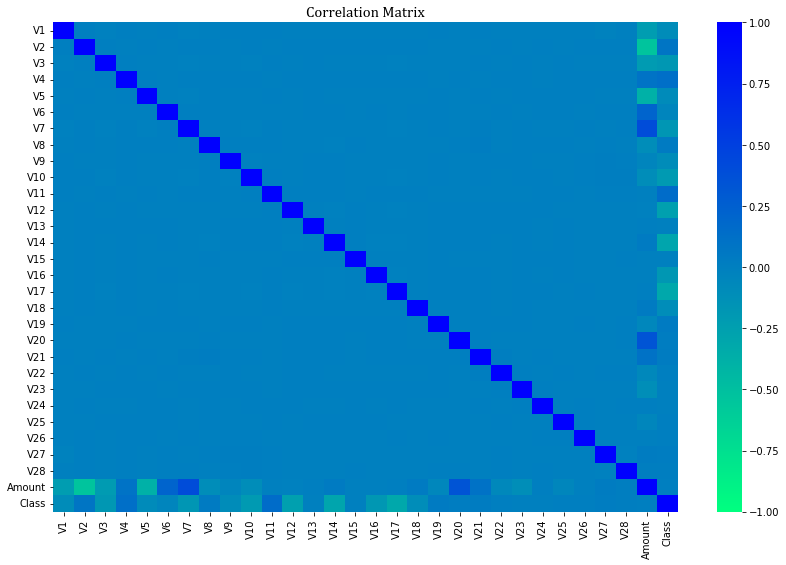

In [83]:
plt.figure(figsize=(14,9))
sns.heatmap(df.corr(method='pearson'), vmin=-1.0, vmax=1.0, cmap='winter_r')
plt.title('Correlation Matrix', fontdict=dict(fontsize=15, fontfamily='Cambria'))
plt.show()

The correlation matrix calculated based on the Pearson correlation statistics for all the variables in the data show no significant positive or negative correlation relationships between the variables. This merely means there is no strong linear dependencies between the variables of the data. However, the target variable Class shows some negative correlation with V12, V14 and V17. <br><br>
It is also interesting to see a slightly higher correlation between Amount and V2, V7. It will be interesting to see a graphical plot of these relationships.

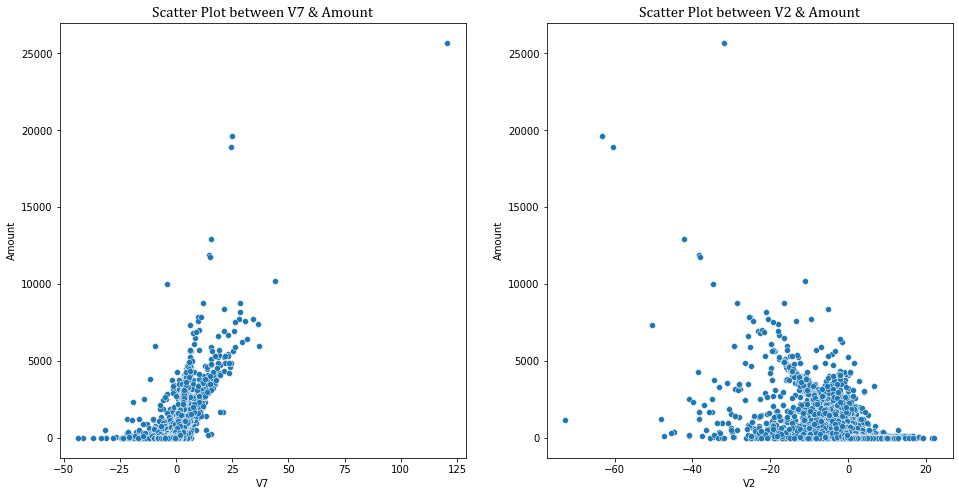

In [52]:
# Scatter plots below
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(x=df['V7'], y=df['Amount'])
plt.title('Scatter Plot between V7 & Amount', fontdict=dict(fontsize=15, fontfamily='Cambria'))

plt.subplot(1,2,2)
sns.scatterplot(x=df['V2'], y=df['Amount'])
plt.title('Scatter Plot between V2 & Amount', fontdict=dict(fontsize=15, fontfamily='Cambria'))
plt.show()

V2 shows a more diverging pattern from the origin (0,0 in the cartesian plane) toward the second quadrant. It is clear that the largest values in Amount and V7 show a relationship, and that could provide the "outlying" anchor for the correlation to exist in first place. It will be interesting to see the relationship without the largest amount value. Graphs below.

In [71]:
max_amount = df['Amount'].max()
max_amount_index = df[df['Amount']==max_amount].index
df.loc[max_amount_index]['Class']

274771    0
Name: Class, dtype: int64

The transaction with the largest amount of 25,691.16 Euros is not a fraud :D

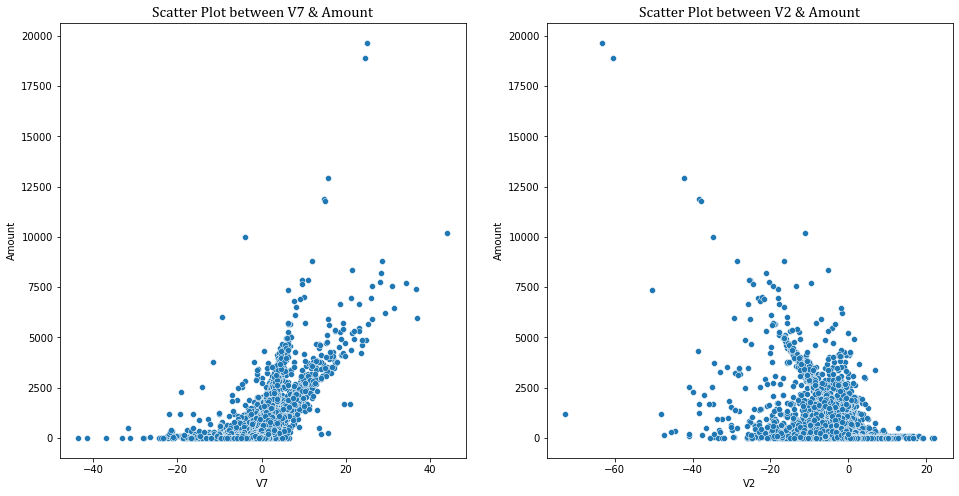

In [55]:
df_without_maxamt = df.drop(max_amount_index, axis=0)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(x=df_without_maxamt['V7'], y=df_without_maxamt['Amount'])
plt.title('Scatter Plot between V7 & Amount', fontdict=dict(fontsize=15, fontfamily='Cambria'))

plt.subplot(1,2,2)
sns.scatterplot(x=df_without_maxamt['V2'], y=df_without_maxamt['Amount'])
plt.title('Scatter Plot between V2 & Amount', fontdict=dict(fontsize=15, fontfamily='Cambria'))
plt.show()

Pretty much the same relationship. To be expected, since the largest amount value is just one value out of 238,000 obsrevations. 

### _Preparations_

In [35]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [73]:
# I am dropping the time variable, I will include it for future iterations of the project.
df = df.drop(['Time'], axis=1)

How are the classes _weighted_? the weights are nothing but essentially asking "for one fraudulent transaction, how many legitimate transactions are in the dataset?" <br><br>
This weight will become the basis for the ML model design as you'll see in later stages of the notebook.<br><br>
Interesting thing is, the class weights are more than just how many transactions there are in the dataset, since that is bound to change in the future. Despite there being 235,000+ transactions in the dataset, merely the number of transactions per class may not be the only way to identify weights. <br><br>
For example, this is where we can use the _transaction Amount_ column to come up with a weight. For example, what is the average amount for a fraudulent transaction compared to a non-fraud transaction - with the hypothesis being that fraudulent transactions have a higher average amount than legitimate transaction.

In [79]:
transaction_weight = round(int(len(df[df['Class']==0])/len(df[df['Class']==1])),0)
amount_weight = df[df['Class']==1]['Amount'].describe()['mean']/df[df['Class']==0]['Amount'].describe()['mean']
print(f'For every fraud transaction, there are approximately {transaction_weight} legitimate transactions in the data.')
print(f'The amount transacted is likely to be {round(amount_weight, 3)} times higher if the transaction is a fraud than if the transaction is legitimate.')

For every fraud transaction, there are approximately 598 legitimate transactions in the data.
The amount transacted is likely to be 1.401 times higher if the transaction is a fraud than if the transaction is legitimate.


We can see this in a basic descriptive statistics for each type of Class

In [158]:
print('Descriptive Statistics of Amount when the transaction is legitimate')
print('------------------------------- ')
print(df[df['Class']==0]['Amount'].describe())
print('------------------------------- ')
print('Descriptive Statistics of Amount when the transaction is fraud')
print('------------------------------- ')
print(df[df['Class']==1]['Amount'].describe())

Descriptive Statistics of Amount when the transaction is legitimate
------------------------------- 
count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64
------------------------------- 
Descriptive Statistics of Amount when the transaction is fraud
------------------------------- 
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Despite the amounts in legitimate transactions having a maximum value 12 times more than than of fraudulent transactions, the mean amount for frauds is 36 eur higher than legit ones.

In [143]:
# It is time to split the dataset into the X MAtrix and the y (target) vector and then tain test split them.
X, y = df.drop('Class', axis=1).values, df['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

In [144]:
columns = df.columns.values.tolist()[:-1]
X_train = pd.DataFrame(X_train, columns=columns)

In [145]:
# Apply StandardScaler
sscaler = StandardScaler()
X_train['Amount'] = sscaler.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2.139297,-2.379957,-0.588094,-2.116887,-0.151810,4.930636,-3.133495,1.408309,0.431508,1.189920,...,-0.379746,-0.073778,0.629693,0.241327,0.738886,-0.314844,0.044060,0.139812,-0.034152,-0.308400
1,-2.150992,0.447565,0.584405,1.181052,0.180772,-1.200828,-0.106578,0.771604,-1.441208,-0.481802,...,0.028937,-0.066225,-0.869480,-0.041398,0.501689,-0.198083,-0.732049,-0.234089,-0.221309,-0.363961
2,-6.000510,-5.868708,-1.210423,2.234168,-0.925608,0.019870,0.012067,0.910109,-0.905567,0.233812,...,0.545803,-0.132715,-0.755490,0.460192,-0.747164,-0.243348,-0.205593,0.915416,-1.136679,1.876398
3,2.021325,-0.535640,-0.416146,-0.124310,-0.178832,0.918878,-1.042599,0.318182,1.072180,0.119271,...,-0.078728,0.020950,0.209552,0.220896,-0.311931,-0.459092,0.495448,-0.012725,-0.051766,-0.359922
4,0.149536,0.807852,-0.590906,-0.509802,1.145394,-1.116329,0.935687,-0.234237,0.014499,-1.110721,...,-0.122272,0.220651,0.679815,-0.349294,-0.734172,0.185243,-0.114120,0.027129,0.015322,-0.344877


In [157]:
# X_test = pd.DataFrame(X_test, columns=columns)
X_test['Amount'] = sscaler.fit_transform(X_test['Amount'].values.reshape(-1,1))
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.684059,1.500809,0.759888,0.550576,0.232439,-0.043998,0.626440,-0.004514,-0.004855,1.376058,...,0.252636,0.099876,0.702279,-0.194992,0.034693,-0.271951,-0.402507,-0.359649,-0.093177,-0.259165
1,-0.712760,0.946364,1.613294,-0.057937,0.307252,0.033698,0.842808,-0.082649,-0.286508,-0.691974,...,0.043267,-0.209533,-0.489587,-0.374907,-0.405319,0.492170,0.339188,-0.107684,0.052013,-0.214710
2,1.194627,0.202019,0.148443,0.456065,-0.024289,-0.105957,-0.146632,0.140367,-0.109165,-0.137806,...,-0.134548,-0.237956,-0.716717,0.114452,-0.366347,0.135195,0.129319,-0.014949,0.012339,-0.328499
3,1.191219,-0.686249,0.413138,0.261424,-0.634744,0.624022,-0.717510,0.123673,-0.737618,0.811951,...,-0.297845,-0.214390,-0.138765,-0.283669,-0.835391,0.646958,-0.177545,0.063255,0.026668,-0.019893
4,0.807040,-1.845157,1.160044,-0.078988,-1.973917,0.492741,-1.211037,0.286344,0.606206,0.173870,...,0.443070,0.253705,0.462592,-0.229476,0.129784,0.251871,-0.111874,0.038918,0.063682,0.602102


In [102]:
X_train = X_train.values

In [108]:
print(f'Lengths of X_train and X_test are: {X_train.shape[0]} & {X_test.shape[0]}')

Lengths of X_train and X_test are: 198608 & 85118


In [118]:
print(round((len(df[df['Class']==1])/len(df))*100, 4), '% of the main data are frauds')
print(round((len(y_train[y_train==1])/len(y_train))*100, 4), "% of the train data are frauds")
print(round((len(y_test[y_test==1])/len(y_test))*100, 4), "% of the test data are frauds")

0.1667 % of the main data are frauds
0.1667 % of the train data are frauds
0.1668 % of the test data are frauds


The _stratify_ option in the train_test_split class of sklearn helps us maintain the same class imbalance ratio as in the original dataset into the train and test datasets. 

Let us remember the weights of the classes once again, before getting to the model designing.

In [119]:
print(transaction_weight, 'legit transactions for 1 fraud.')

598 legit transactions for 1 fraud.


Highly imbalanced classification problems are not uncommon in the domain of financial fraud, as there would only be a handful of fraudulent transactions compared to legitimate transactions.<br>
* For example, in this dataset, 99.83% of the records are legitimate, whereas only 0.17% of the records are fraudulent trasnsactions.
* The sensible approach to the problem at hand is to not only look at correct classification (in terms of accuracy, which will be useless as a metric for evaluation anyways), but also the financial cost involved. <br><br>
For example, the "cost" of misclassifying a non-fraud as a fraud is not going to be as high as the cost of misclassifying a fraud as a non-fraud. <br>
Moreover, we also need to think about individual transaction examples, and the costs attached to it. So instead of having two different costs for two different Classes (fraud and non-fraud), there would be a cost matrix for each row of data. Ideally, this <i> <a href='https://albahnsen.github.io/CostSensitiveClassification/index.html'> example dependent cost-sensitive classification </a></i> would be the way to go. <br><br>
Several approaches for imbalanced data classification is to use an <i>undersampler or an oversampler</i>, with techniques such as SMOTE (Synthetic Minority Oversampling Technique), RandomOverSampler, RandomUnderSampler, TomekLinks, etc. used predominantly. I however, do not want to use such resampling techniques for this problem - but want to experiment with the <i>class weights</i> to come up with a rational and meaningful set of class weights (frauds and non-frauds) to classify the data more accurately. <br><br>
With such severe imbalance, undersampling is prone to remove a lot of existing information in the Non-Fraud part of the data. Oversampling is prone to create non-existent patterns in the Fraudulent part of the data - especially distance based oversampling techniques where a random point in the middle of the euclidean space between two existing fraudulent points are calculated as a new point. <br><br> With only 473 total frauds, I do not want to implement either of these techniques. <br><br>
To calculate the class weights, one way to approach this is to take simply, the obervation weights of the classes in the data. The following line of code tells us that for each fraud transaction, there are approximately 598 legitimate transactions in the dataset. <br><br>
So when ensemble classification techniques tries to minimize the loss function, the attached weight of 598 for Class 1 will reinforce the misclassification cost of misclassifying Fraudulent transactions. <br><br> This is a way of deliberately inducing bias in the model's loss calculation, to account for the imbalance avoiding resampling techniques and the disadvantages that comes with it - both statistically and financially.

<br><br><br>
In the first step toward approaching this problem, I am going to use the Random Forest classification algorithm, with some hyperparameter tuning using the GridSearch CV. Optimizing for time and for the accuracy/evaluation metrics, I will then fine tune the main parameter of interest - the "class_weight" where a dictionary of key-value pairs for the class and the respective weight I want the Random Forest algorithm to calculate the loss with, is provided. <br><br>
Below is a list of all the parameters of the Random Forest for reference.

In [122]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [124]:
# I am going to now fine tune the RandomForest Classification model based on several hyperparameter options, one of which is the class_weight
param_grid = [
    {'criterion':['entropy', 'gini'],
    'class_weight':[{0:1, 1:transaction_weight}, {0:1, 1:50}, None],
    'n_estimators':[50, 100]}
]
random_forest = RandomForestClassifier(random_state=42, max_depth=5, ccp_alpha=0.01)

gridsearch = GridSearchCV(random_forest, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=3)
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=50;, score=0.974 total time=  20.7s
[CV 2/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=50;, score=0.981 total time=  20.3s
[CV 3/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=50;, score=0.982 total time=  26.7s
[CV 1/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=100;, score=0.975 total time=  46.4s
[CV 2/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=100;, score=0.981 total time=  44.8s
[CV 3/3] END class_weight={0: 1, 1: 598}, criterion=entropy, n_estimators=100;, score=0.988 total time=  50.7s
[CV 1/3] END class_weight={0: 1, 1: 598}, criterion=gini, n_estimators=50;, score=0.973 total time=  16.8s
[CV 2/3] END class_weight={0: 1, 1: 598}, criterion=gini, n_estimators=50;, score=0.966 total time=  17.2s
[CV 3/3] END class_weight={0: 1, 1: 598}, criterion=gini, n_es

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(ccp_alpha=0.01, max_depth=5,
                                              random_state=42),
             param_grid=[{'class_weight': [{0: 1, 1: 598}, {0: 1, 1: 50}, None],
                          'criterion': ['entropy', 'gini'],
                          'n_estimators': [50, 100]}],
             scoring='roc_auc', verbose=3)

In [125]:
gridsearch.best_params_

{'class_weight': {0: 1, 1: 598}, 'criterion': 'entropy', 'n_estimators': 100}

As the theoretical understanding of the problem would expect, the best class weight parameter is indeed the one containing the transaction support for the two classes. {0: 1, 1: 598} is the best class_weight parameter, compared to a randomly higher weight for Class = 1 (frauds), and the default "None" option. 

In [131]:
training_prediction = gridsearch.predict(X_train)
training_cm = confusion_matrix(y_train, training_prediction)
print(training_cm)

[[197341    936]
 [    36    295]]


This is the confusion matrix results for the Training Data - not the test dataset which we use to evaluate our model. <br><br>
The interpretation of the confusion matrix is such as: <br><br>
197341 legitimate transactions were predicted as legitimate transactions. <br>
295 fraudulent transactions were predicted as fraudulent transactions. <br>
36 fraudulent transactions were predicted as legitimate transactions.<br>
936 legitimate transactions were predicted as fraudulent transactions. <br>

<br>
In order to understand the model results further, let us look at the "classification report" after we make predictions on the testing data using the model.

In [210]:
predicted_y = gridsearch.predict(X_test)
scores_y = gridsearch.predict_proba(X_test)
cm = confusion_matrix(y_test, predicted_y)
print(cm)

C:\Users\gopalnit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\gopalnit\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[84579   397]
 [   24   118]]


In [135]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.23      0.83      0.35       142

    accuracy                           0.99     85118
   macro avg       0.61      0.91      0.68     85118
weighted avg       1.00      0.99      1.00     85118



The recall score of 83% means that, "of all the frauds in the test dataset, how many were correctly identified?" <br><br>
The recall is essentially True Positives/(True Positives + False Negatives)<br>
False negatives are the actual frauds that were missed and identified (predicted) as legitimate. This has a high financial cost. <br>
True positives are actual fraudulent transactions that were correctly identified as frauds. <br><br>
False positives on the other hand, are actual legitimate transactions that were mistaken as frauds. This does not hold a high financial cost comapred to false negatives.<br><br>
You can see how by increasing the class weight of the Fraud class by too much, is prone to give us more false positives, because the RandomForest mis-idenitifies many more normal transactions as fraudulent. The upside is that we may get more of the actual frauds correctly predicted. <br><br>
By reducing the weight of the fraud class lower than the optimal weight, the RandomForest is more prone to predict actual frauds as non-frauds, but identify many more legitimate transactions correctly. So, the metric-based goal of this project is to find that reasonable correct class weight to get to an equilibrium trade-off between the False positives and False negatives /or/ between precision and recall. <br><br>
Recall, naturally seems more attractive as a metric to optimize, since recall calculates "how many of actual frauds were correctly identified as frauds?" - or, the inverse of how many actual frauds we missed? <br>

| Actual/Predicted | Legit | Fraud |
|------------------|-------|-------|
| Legit            | 84571 |  405  |
| Fraud            |   24  |  118  |

In a financial sense, the goal is to minimize the cost of misclassifying the data - except in this case, one cost is greater than the other. Cost of misclassifying a fraud as legit has a much greater cost than vice versa. <br><br>
Let us look at a theoretical cost model as below: <br>
* Actually legit - predicted as legit = no cost involved.
* Actually legit - predicted as fraud = administrative cost of raising an alert, verification, etc.
* Actually fraud - predicted as fraud = administrative cost of raising an alert, verification, etc.
* Actually fraud - predicted as legit = cost of the transaction amount, or possibly more. <br><br>
When scaled, the admin cost is minimized, and that is why theoretically I believe that the cost of a false negative on average will be much greater than a false positive. <br><br>

So, based on this cost model, this could be a sample equation: <br>
_cost_ = 0 x _TN_ + A x _TP_ + A x _FP_ + Amt x _FN_ <br><br>
Where A is the admin cost, and Amt is the transaction amount average for when the transaction is a fraud.

In [161]:
# Let us recall the average amount for when a transaction is fraudulent.
fraud_avg_amt = df[df['Class']==1]['Amount'].describe()['mean']
print(f'The average fraudulent transaction has an amount of {round(fraud_avg_amt,2)} Euros')

The average fraudulent transaction has an amount of 123.87 Euros


In [166]:
cost = cm[0][0]*0 + cm[0,1]*5 + cm[1,0]*fraud_avg_amt + cm[1][1]*5
print(f'The approximated financial cost/savings of the initial Random Forest model is: {round(cost,2)} Euros')

The approximated financial cost/savings of the initial Random Forest model is: 5587.92 Euros


<br><br>
The transaction based weight of {0:1, 1:598} gave us a lot of false positives at the expense of minimal false negatives. Let us try reducing the weight given to class 1, such that the false positives are reduced, but do so in a manner of not losing too much through false negatives. <br><br>
Essentially, let us compare the precision and recall and come to the best compromise possible to minimize the cost involved from the equation above.

In [188]:
# Classification report for the GridSearched Random Forest Model #1
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.23      0.83      0.35       142

    accuracy                           0.99     85118
   macro avg       0.61      0.91      0.68     85118
weighted avg       1.00      0.99      1.00     85118



The more recall score we want, the lesser the precision score is bound to get. So, the tradeoff should be made in a meaningful way. For example, from a financial company's standpoint, 83% of all the frauds being correctly predicted as frauds may be a good result (actually isn't), but at the cost of only 23% of the predicted data being corrected predicted. <br><br>
The way to approach this particular scenario is to battle it out using the financial costs and which cost is minimal, based on different precision and recall values (which are essentially just combinations of TP, FP, TN and FNs.)

### _<b>3. The Last Lap</b>_

Time to modularize the modelling to make it easier to test with different weights.

In [201]:
def model(weights):
    random_forest = RandomForestClassifier(ccp_alpha=0.01, 
                                        class_weight=weights,
                                        criterion='entropy',
                                        max_depth=5,
                                        random_state=42)
    random_forest.fit(X_train, y_train)
    predictions = random_forest.predict(X_test)
    print(f'The results of the model with weights {weights} are:')
    print('The confusion matrix')
    print('-------------------------')
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    print('---------------------------')
    print(classification_report(y_test, predictions))
    print('------------------------------------------')
    print('The Financial Cost of the model')
    print('-----------------------')
    print(cm[0][0]*0 + cm[0][1]*5 + cm[1][1]*5 + cm[1][0]*fraud_avg_amt, 'Euros')
    scores = random_forest.predict_proba(X_test)
    print(f'The ROC-AUC score is {roc_auc_score(y_test, scores[:,1])}')

In [203]:
weights_list = [{0:1, 1:15}, {0:1, 1:50}, {0:1, 1:100}, {0:1, 1:150}, {0:1, 1:200}, {0:1, 1:275}, {0:1, 1:350}, {0:1, 1:400}, {0:1, 1:475}, {0:1, 1:550}]
for weights in weights_list:
    model(weights)

The results of the model with weights {0: 1, 1: 15} are:
The confusion matrix
-------------------------
[[84960    16]
 [   36   106]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.87      0.75      0.80       142

    accuracy                           1.00     85118
   macro avg       0.93      0.87      0.90     85118
weighted avg       1.00      1.00      1.00     85118

------------------------------------------
The Financial Cost of the model
-----------------------
5069.3869767441865 Euros
The ROC-AUC score is 0.94457283382085
The results of the model with weights {0: 1, 1: 50} are:
The confusion matrix
-------------------------
[[84954    22]
 [   31   111]]
---------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.83      0.78      0.81       142

    accuracy         

In [217]:
weights_for_fraud = [weight[1] for weight in weights_list]
weights_for_fraud.append(598)
roc_auc = [0.94457283382085, 0.9647444365401598, 0.9653423269801449, 0.9684870425717551, 
            0.9697317602186267, 0.9680578824576151, 0.9715269646972401,
            0.9712566315327475, 0.9728178428507404, 0.9732064364155181, 0.9729580647128866]
model_costs = [5069.3869767441865, 4505.027674418605, 4451.155813953488,
                4248.412093023257, 4283.412093023257, 4503.412093023257, 4605.668372093023,
                4666.7965116279065, 4922.924651162791, 5277.924651162791, 5587.92]

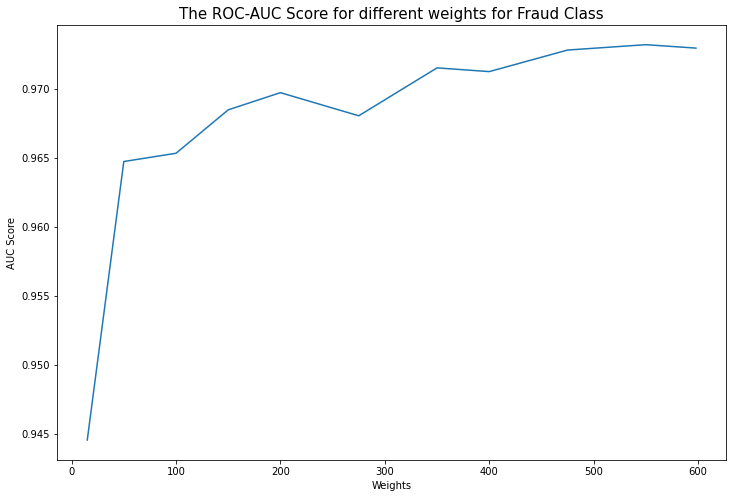

In [215]:
plt.figure(figsize=(12,8))
sns.lineplot(x=weights_for_fraud, y=roc_auc)
plt.title('The ROC-AUC Score for different weights for Fraud Class', fontdict=dict(fontsize=15))
plt.xlabel('Weights')
plt.ylabel('AUC Score')
plt.show()

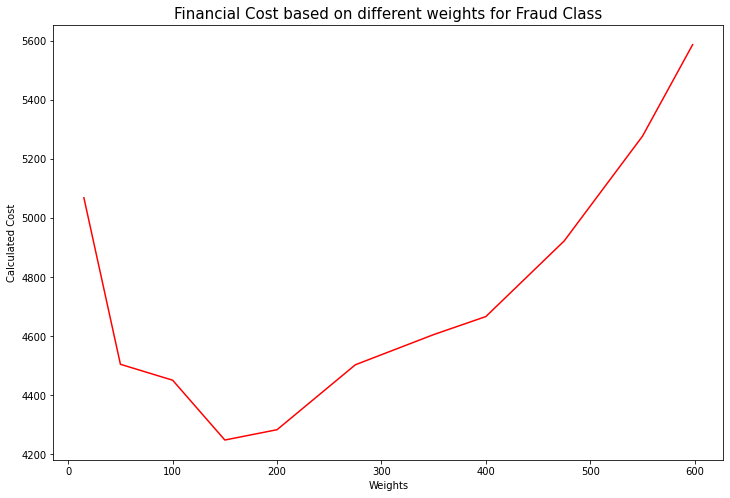

In [223]:
plt.figure(figsize=(12,8))
sns.lineplot(x=weights_for_fraud, y=model_costs, color='red')
plt.title('Financial Cost based on different weights for Fraud Class', fontdict=dict(fontsize=15))
plt.xlabel('Weights')
plt.ylabel('Calculated Cost')
plt.show()

We see that the lowest cost is attained for the weights combination of {0:1, 1:150}. The approach to selecting the best model will depend on the business goals of the project.<br><br>
Even if the AUC score gets higher but plateauingly so, the financial savings based on the equation made from the confusion matrix gives us an increasing cost as the weights given to the Fraud Class increases. This is because: <br><br>
* Higher weight emphasizes the importance of misclassifying Class 1 (Fraud), thereby greatly increasing the False Positives in the prediction. The increase in False Positives are great because _most of the data in the training and testing is Non-Fraud (Class 0)._ Thereby, the algorithm gets "over-cautious" in a way when predicting frauds.
* Increasing weights needs to be rationale driven - the weight of 598 is a simple way to create a baseline model by understanding the sample support in the data. Ultimately, the financial cost comes down to the compromise between false negatives and the false positives. But either way, predicting as much actual frauds as frauds will always be the ultimate goal of the model. 
* If we did not have any cost for a False Positive at all, then the model can go wild, and create as much False Positives as it can, to get as less False Negatives as possible. But that is not a scalable way to model, nor is it practical.<br><br>
For a heavily imbalanced dataset such as fraud detection, SMOTE-type oversampling is not reasonable since it is not scalable, and is prone to creating non-existent patterns due to the distance based approach it takes to create new data. <br> The loss of information from undersampling is also a cause for concern, and even witha shuffled approach, where different parts of the data is taken to be trained on after undersampling, it will not create an accurate model, enough to generalize.

The confusion matrix for the Best-Cost model is: <br>
| Actual/Predicted | Legit | Fraud |
|------------------|-------|-------|
|       Legit      | 84934 |   42  |
|       Fraud      |   28  |  114  |

There are more legitimate transactions predicted accurately than the baseline, but 4 fraudulent transactions predicted less. But, and a big BUT, there are 362 lesser false positives. And that is where most of the reduction in the Cost comes from. <br><br>
_<b>For a 3% sacrifice in recall, we have 50% increase in Precision, thereby, generating overall savings from the baseline model. </b>_

### _<b>4. The End</b>_

CAUTION:<br>
This is in no way an acceptable model, but a strong showcase on domain-specific design of ML models. <br>
Some takeaways for future iterations:<br>
* Only one algorithm is tried, where XGBoost and Neural Networks can work better at predicting frauds in such a heavily imbalanced dataset.
* Not blaming data privacy issues, some more feature extraction can be looked into.
* Coming up with reasonably accurate weighting for different classes can be useful for the future.
* KFold Cross validated Train-Test Split can be applied. Despite the 70% data taken for training would contain the nuances and distributional idiosyncrasies of the different variables in the X-matrix, there is always room to improve the model selection process, which will help the algorithm look at an accurate representation of the entire dataset - to not overfit on training data, and generalize well on the testing data.<br>

❤️ More attention and resources given to the project and the processes can yield a better and more sustainable model for use. I hope this project was of help to understand the domain of fraud detection a little bit more, as I myself learn more each and every day! 😊 Thanks for reading ❤️ Long live the community. ❤️